In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import lightning as L 

torch.__version__, L.__version__

('2.0.0+cu118', '2.0.0')

# LeNet

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/models/1998_lenet.ipynb)

LeNet 5 is one of the first convolutional neural networks. It was introduced in 1998 by [Yann LeCun et al.](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) and it was used to classify handwritten digits. It was the first network that was able to achieve a high accuracy on this task.

![lenet5](pics/lenet5.png)

In [3]:
def block(ci, co, k=5, s=1, p=0):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, k, s, p),
        torch.nn.Tanh(),
        torch.nn.AvgPool2d(2, stride=2)
    )

class LeNet5(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = block(1, 6)
    self.conv2 = block(6, 16)
    self.conv3 = torch.nn.Sequential(
        torch.nn.Conv2d(16, 120, 5, padding=0),
        torch.nn.Tanh()
    )
    self.fc1 = torch.nn.Sequential(
        torch.nn.Linear(120, 84),
        torch.nn.Tanh()
    )
    self.fc2 = torch.nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [4]:
lenet5 = LeNet5()
output = lenet5(torch.randn(64, 1, 32, 32))
output.shape

torch.Size([64, 10])

In [5]:
import torchvision

dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=36, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=36, shuffle=False, pin_memory=True)
}

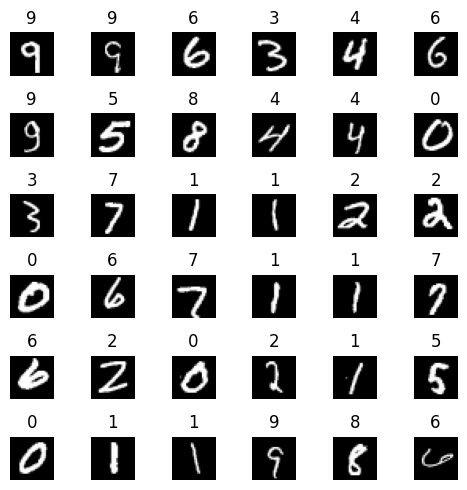

In [6]:
# plot images

import matplotlib.pyplot as plt

imgs, labels = next(iter(dataloader['train']))

rs, cs = 6, 6 
fig, axs = plt.subplots(rs, cs, figsize=(5,5))
for i, (x, y) in enumerate(zip(imgs, labels)):
	ax = axs[i//cs, i%cs]
	ax.imshow(x[0], cmap='gray')
	ax.set_title(y.item())
	ax.axis('off')
plt.tight_layout()
plt.show()
    

Since the model is designed to work with 32 x 32 inputs, and MNIST images are 28 x 28, we will pad the images with two pixels of zeros around the border. 

In [7]:
model = torch.nn.Sequential(
    torch.nn.ConstantPad2d(2, 0.),
    LeNet5()
)

output = model(imgs)
output.shape

torch.Size([36, 10])

In [10]:
from convnets.train import fit
from convnets.metrics import error

dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=36, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=36, shuffle=False, pin_memory=True)
}

model = torch.nn.Sequential(
    torch.nn.ConstantPad2d(2, 0.),
    LeNet5()
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metrics = {'error': error}

# hist = fit(model, dataloader, optimizer, criterion, metrics, device=device, max_epochs=20, after_epoch_log=False)
hist = fit(model, dataloader, optimizer, criterion, metrics, max_epochs=20)


KeyboardInterrupt: 

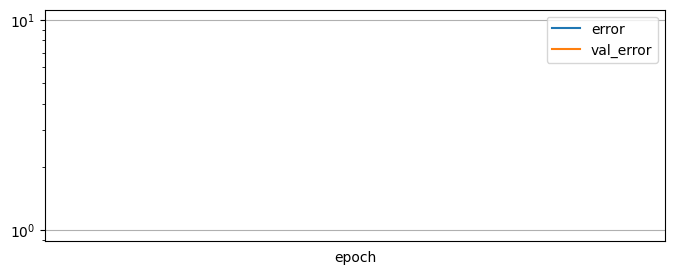

In [ ]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
df.plot(x='epoch', y ='error', ax=ax, logy=True, xticks=df.epoch.values)
df.plot(x='epoch', y ='val_error', ax=ax, logy=True, xticks=df.epoch.values)
plt.grid(True)
plt.show()

Error rate on the test set reported on the original paper is around 1%, which we have been able to reproduce.